# EDA: first steps with LSTM for timeseries prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [2]:
data=pd.read_csv('../data/bitcoin_price.csv')

data['Date']=pd.to_datetime(data['Date'], format='%b %d, %Y')
close_price = data[['Date','Close']]
close_price.index = close_price['Date']
close_price_ts=close_price['Close']

# chronological order
close_price_ts=close_price_ts.sort_index()
close_price_ts.head()

Date
2013-04-28    134.21
2013-04-29    144.54
2013-04-30    139.00
2013-05-01    116.99
2013-05-02    105.21
Name: Close, dtype: float64

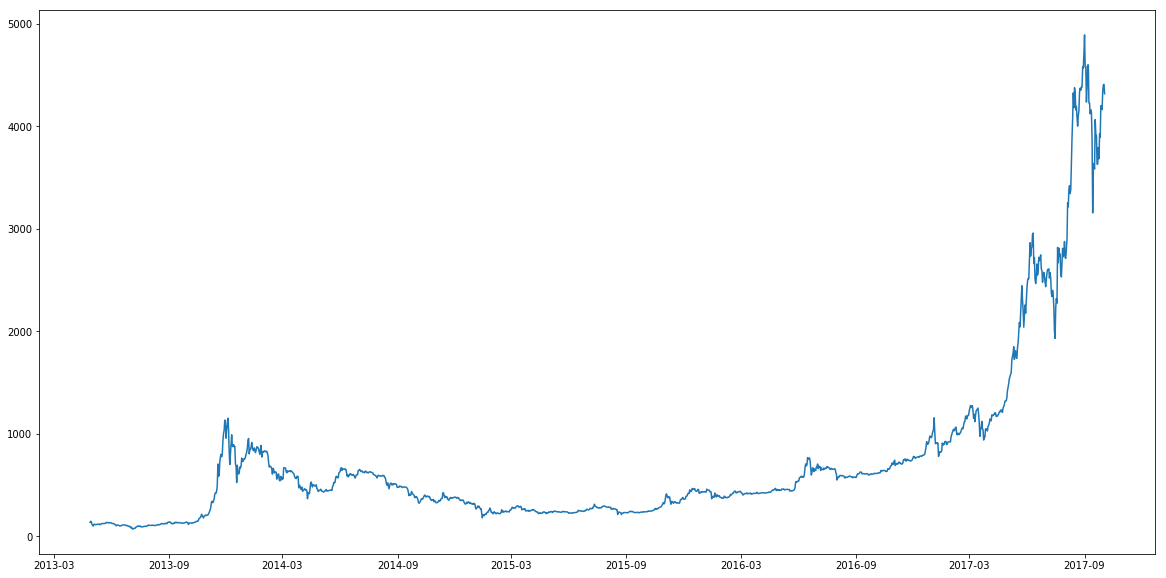

In [3]:
plt.plot(close_price_ts)
plt.show()

In [4]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [5]:
# fix random seed for reproducibility
np.random.seed(7)

In [6]:
data1 = pd.concat([close_price_ts.shift(1), close_price_ts], axis=1).dropna()
data1.columns = ['t-1', 't']
data1.head()

,t-1,t
Date,,
2013-04-29,134.21,144.54
2013-04-30,144.54,139.00
2013-05-01,139.00,116.99
2013-05-02,116.99,105.21
2013-05-03,105.21,97.75


In [7]:
X=data1['t-1'].values
y=data1['t'].values

In [8]:
ratio_train=0.9
n=len(X)
n_train=int(ratio_train*n)

X_train,X_test=X[:n_train],X[n_train:n]
y_train,y_test=y[:n_train],y[n_train:n]


## Baseline: Persistence model 

In [9]:
def persistence_model(x):
    return x

In [10]:
# predictions with persistence model
predictions=[]

for x in X_test:
    pred = persistence_model(x)
    predictions.append(pred)

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# evaluation
mae_baseline = mean_absolute_error(y_test,predictions)
mse_baseline = mean_squared_error(y_test,predictions)
r2_baseline = r2_score(y_test,predictions)

print('MAE: %.9f' % mae_baseline)
print('MSE: %.9f' % mse_baseline)
print('R2: %.9f' % r2_baseline)

MAE: 106.672901235
MSE: 23404.131931481
R2: 0.974608209


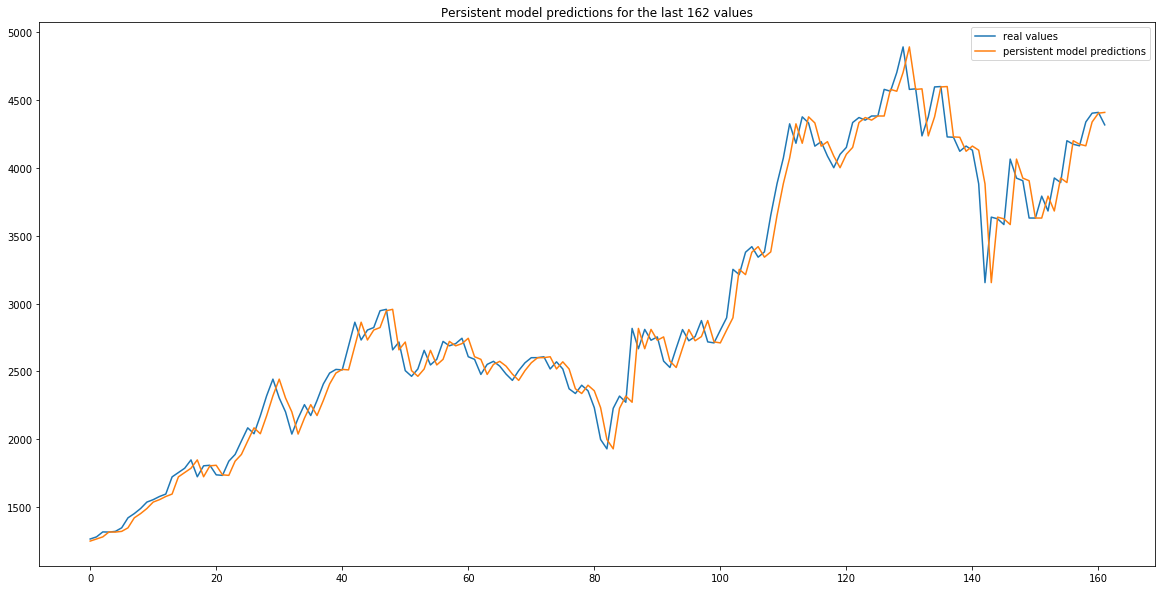

In [12]:
plt.plot(y_test,label='real values')
plt.plot(predictions,label='persistent model predictions')
plt.title('Persistent model predictions for the last %d values'%len(X_test))
plt.legend()
plt.show()

## Data Preprocessing

### Transform into stationnary signal

Data shows a trend (increasing). No seasonality seems to be present.

In [13]:
# function that transform the entire signal into a stationnary one through differencing
def difference(dataset, interval=1):
    diff=[]
    for i in range(interval, len(dataset)):
        value = dataset[i]-dataset[i-interval]
        diff.append(value)
    
    return pd.Series(diff)

# function that gives the real value from the prediction based on the stationnary signal
def inverse_difference(history, pred, interval=1):
    return pred + history[-interval]


In [14]:
# transform signal
interval=1
stationnary = difference(close_price_ts,interval)

In [15]:
# check that functions are properly working
print(stationnary.head())
print('')
inverse = []

for i in range(len(stationnary)):
    val = inverse_difference(close_price_ts, stationnary[i],len(close_price_ts)-i)
    inverse.append(val)
    
inv_ser = pd.Series(inverse)

print(inv_ser.head())
print('')
print(close_price_ts.head())

0    10.33
1    -5.54
2   -22.01
3   -11.78
4    -7.46
dtype: float64

0    144.54
1    139.00
2    116.99
3    105.21
4     97.75
dtype: float64

Date
2013-04-28    134.21
2013-04-29    144.54
2013-04-30    139.00
2013-05-01    116.99
2013-05-02    105.21
Name: Close, dtype: float64


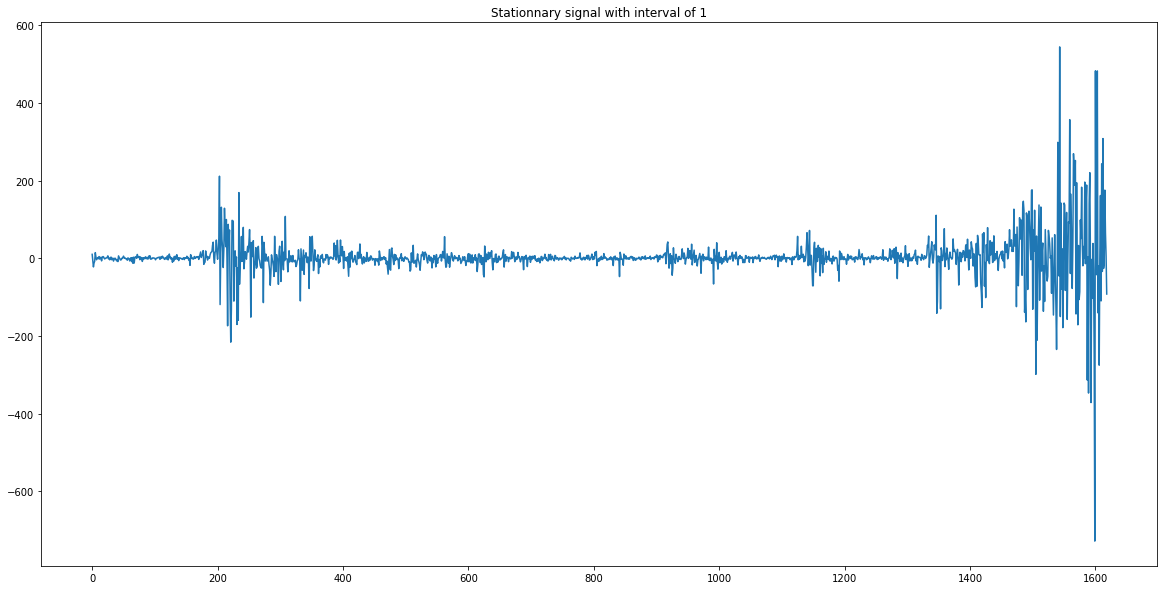

In [16]:
plt.plot(stationnary)
plt.title('Stationnary signal with interval of %d'%interval)
plt.show()

### Transform into supervised learning problem

In [17]:
nb_lags = 1

df = pd.DataFrame(stationnary.values)

columns = [df.shift(i) for i in range(1,nb_lags+1)]
headers = ['t-%d'%i for i in range(1,nb_lags+1)]

columns.append(df)
headers.append('t')

data2=pd.concat(columns, axis=1).dropna()
data2.columns=headers
data2.head()

,t-1,t
1,10.33,-5.54
2,-5.54,-22.01
3,-22.01,-11.78
4,-11.78,-7.46
5,-7.46,14.75


### Transform to scale

Data is expected by LSTM to be within the values taken by its activation functions. The default activation function for LSTM is tanh which has values between -1 and 1. 

In [18]:
# scale train and test data to [-1,1]

def scale(train,test):
    # fit on train
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(train)
    
    # transform train
    train_scaled = scaler.transform(train)
    
    # transform test
    test_scaled = scaler.transform(test)
    
    return train_scaled, test_scaled, scaler

    
    

In [19]:
# split into train and test
data2_values=data2.values
train,test=data2_values[:n_train],data2_values[n_train:]

In [20]:
# normalize the dataset (inverse_transform to inverse the normalistion)
train,test,scaler=scale(train,test)


## LSTM

In Keras, one LSTM layer expect the following three types of information as input: **samples**, **time steps** and **features**. Therefore, we need to reshape the data accordingly.

In [21]:
# reshape training data according to "samples", "time steps" and "features"
X,y=train[:,:-1],train[:,-1]

nb_samples=X.shape[0]
nb_features=X.shape[1]
time_step=1
X=X.reshape(nb_samples,1,nb_features)

nb_neurons=5
batch_size=32
nb_epoch=100

model=Sequential()
model.add(LSTM(nb_neurons,batch_input_shape=(batch_size,time_step,nb_features),stateful=True))
model.add(Dense(1))

model.compile(loss='mean_squared_error',optimizer='adam')

for i in range(nb_epoch):
    model.fit(X,y,epochs=1,batch_size=batch_size,verbose=0,shuffle=0)
    model.reset_states()